In [1]:
import cvxpy as cvx
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import lognorm
import functools
from IPython.display import Image
import pygraphviz

# Question 1: Smoothed fit to given data 

The structure of the hessian is tridiagonal as each value is connected to the predecessor and the successor.

# Question 2: Maximum likelihood prediction of team ability

$n$ teams with abiliy $a_j \in [0, 1]$ ($j = 1 \dots n$) competes in a tournament.

The probability that team $j$ wins against team $k$ is:

$\mathbf{prob}(a_j−a_k+v>0)$,

where $v ∼ \mathcal{N}(0,\sigma^2)$.

The output of $m$ games is given as:

$(j^{(i)},k^{(i)},y^{(i)}),i=1, \dots,m$

$y^{(i)}=1$ means that team $j^{(i)}$ won, while $y^{(i)}=−1$ means that team $k^{(i)}$ won (no ties).

**Task:**

Formulate the problem of finding the maximum likelihood estimate of team abilities $\hat{a} \in \mathcal{R}^n$ as convex optimization problem. The game incidence matrix $A^{m \times n}$ an be used:

$
  A_{il}=\begin{cases}
\begin{align}
               y^{(i)} && l=j^{(i)}\\
               -y^{(i)} && l=k^{(i)}\\
               0 && \mathrm{otherwise}
            \end{align}
            \end{cases}
$

The probability for team $j$ winning against team $k$ is:

\begin{align}
\mathbf{prob} (a_j - a_k + v > 0 ) &=& \mathbf{prob} (v < a_j - a_k )\\
& = & \mathbf{norm\_cdf}(1/\sigma \, (a_j - a_k))
\end{align}

The probability for team $k$ winning against team $j$ is:

\begin{align}
\mathbf{prob} (a_k - a_j + v > 0 ) &=& \mathbf{prob} (v < -(a_j - a_k) )\\
& = & \mathbf{norm\_cdf}(-1/\sigma \, (a_j - a_k))
\end{align}

More generally, the probability that in the $i$th game the outcome was $y^{(i)}$ is therefore:

\begin{align}
p(y^{(i)}|a_j, a_k) = \mathbf{norm\_cdf}(1/\sigma \, (a_j - a_k))
\end{align}

The total likelihood that all matches have the observed outcome is then:

\begin{align}
p(y|a) = \prod_{i=1}^n \mathbf{norm\_cdf}(y^{(i)}/\sigma \, (a_{j^{(i)}} - a_{k^{(i)}}))
\end{align}

And the desired log-likelihood is given by:

\begin{align}
l(a) = \log p(y|a) = \sum_{i=1}^n \log \mathbf{norm\_cdf}(\frac{1}{\sigma} (\mathrm{A}a)_i)
\end{align}

This is a concave function so maximizing the log likelihood over $a$ is a convex optimization problem:

\begin{align}
\mathbf{maximize}&& l(a)\\
\mathbf{subject\, to}&& 0 \leq a \leq 1\,,\, i=1, \dots, n
\end{align}

In [2]:
n = 10  # Number of teams
m = 45  # Number of training matches
m_test = 45  # number of test matches
sigma = 0.25  # standard deviation of the underlying normal distribution (with zero mean)

In [3]:
train = np.array(
    [
        [1, 2, 1],
        [1, 3, 1],
        [1, 4, 1],
        [1, 5, 1],
        [1, 6, 1],
        [1, 7, 1],
        [1, 8, 1],
        [1, 9, 1],
        [1, 10, 1],
        [2, 3, -1],
        [2, 4, -1],
        [2, 5, -1],
        [2, 6, -1],
        [2, 7, -1],
        [2, 8, -1],
        [2, 9, -1],
        [2, 10, -1],
        [3, 4, 1],
        [3, 5, -1],
        [3, 6, -1],
        [3, 7, 1],
        [3, 8, 1],
        [3, 9, 1],
        [3, 10, 1],
        [4, 5, -1],
        [4, 6, -1],
        [4, 7, 1],
        [4, 8, 1],
        [4, 9, -1],
        [4, 10, -1],
        [5, 6, 1],
        [5, 7, 1],
        [5, 8, 1],
        [5, 9, -1],
        [5, 10, 1],
        [6, 7, 1],
        [6, 8, 1],
        [6, 9, -1],
        [6, 10, -1],
        [7, 8, 1],
        [7, 9, 1],
        [7, 10, -1],
        [8, 9, -1],
        [8, 10, -1],
        [9, 10, 1],
    ]
)
# subtract 1 as python starts indexing with 0 as opposed to Matlab which starts with 1
train[:,0] -= 1
train[:,1] -= 1

In [4]:
test = np.array(
    [
        [1, 2, 1],
        [1, 3, 1],
        [1, 4, 1],
        [1, 5, 1],
        [1, 6, 1],
        [1, 7, 1],
        [1, 8, 1],
        [1, 9, 1],
        [1, 10, 1],
        [2, 3, -1],
        [2, 4, 1],
        [2, 5, -1],
        [2, 6, -1],
        [2, 7, -1],
        [2, 8, 1],
        [2, 9, -1],
        [2, 10, -1],
        [3, 4, 1],
        [3, 5, -1],
        [3, 6, 1],
        [3, 7, 1],
        [3, 8, 1],
        [3, 9, -1],
        [3, 10, 1],
        [4, 5, -1],
        [4, 6, -1],
        [4, 7, -1],
        [4, 8, 1],
        [4, 9, -1],
        [4, 10, -1],
        [5, 6, -1],
        [5, 7, 1],
        [5, 8, 1],
        [5, 9, 1],
        [5, 10, 1],
        [6, 7, 1],
        [6, 8, 1],
        [6, 9, 1],
        [6, 10, 1],
        [7, 8, 1],
        [7, 9, -1],
        [7, 10, 1],
        [8, 9, -1],
        [8, 10, -1],
        [9, 10, 1],
    ]
)
# subtract 1 as python starts indexing with 0 as opposed to Matlab which starts with 1
test[:,0] -= 1
test[:,1] -= 1

In [5]:
A = (
    csr_matrix((train[:, 2], (np.arange(m), train[:, 0])), shape=(m,n))
    + csr_matrix((-train[:, 2], (np.arange(m), train[:, 1])), shape=(m,n))
)

Unfortunately the mentioned cvx function $\mathbf{log\_normcdf}$ does not exist for cvxpy. However, the matlab implementation given here https://github.com/cvxr/CVX/blob/master/functions/%40cvx/log_normcdf.m can be ported to python:

In [6]:
def log_normcdf(x):
    a = np.diag(
        np.sqrt(
            [
                0.018102332171520,
                0.011338501342044,
                0.072727608432177,
                0.184816581789135,
                0.189354610912339,
                0.023660365352785,
            ]
        )
    )
    b = np.array([[3, 2.5, 2, 1, -1, -2]]).T
    
    nx = functools.reduce(lambda i, j: i * j, x.shape)
    
    y  = a @ ( b @ np.ones((1, nx)) - np.ones(b.shape) @ cvx.reshape( x, (1, nx) ) )
    y = -cvx.sum((cvx.maximum(y, 0))**2, axis=0)

    return cvx.reshape(y, x.shape)

In [7]:
a_hat = cvx.Variable(n, nonneg=True)

objective = cvx.Maximize(cvx.sum(log_normcdf(A @ a_hat / sigma)))

constraints = [
    a_hat <= 1.,
]

problem = cvx.Problem(objective, constraints)

problem.solve()

-11.44871475843284

In [8]:
list(a_hat.value)

[1.0,
 0.0,
 0.6828668359927551,
 0.36964924413699435,
 0.794624430145803,
 0.577875954115459,
 0.3794723150927706,
 0.08950883318437884,
 0.6736308886155367,
 0.577875954115459]

In [9]:
# Compare with test data
# A tie in a is evaluated as a win for the j against k
predictions = ((a_hat.value[test[:,0]] - a_hat.value[test[:,1]]) >= 0) * 2 -1
predictions

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1])

In [10]:
print(f"Fraction of orrect predictions on the test data: {(predictions == test[:, 2]).mean()}")

Fraction of orrect predictions on the test data: 0.8666666666666667


In [11]:
print(f"Fraction of correct predictions when repeating the results from the training data: {(train[:, 2] == test[:, 2]).mean()}")

Fraction of correct predictions when repeating the results from the training data: 0.7555555555555555


# Question 3:  Allocation of interdiction effort 

A smuggler moves along a directed, acyclic graph in a way to maximize the combined detection failure $\prod_{j \in P} p_j$, where $P \subset {1, \dots,m}$ is (the set of edges on) the smuggler's path.

Detection failure can be minimized by adding resources to individual edges. The maximum combined detection failure $P^{\mathrm{max}}$ should be minimized in this exercise.

* $x_j \in R^+$: effort (say, yearly budget) allocated to edge $j$. Variable to be optimized to minimize $P^\mathrm{max}$
* $p_j = e^{−a_j x_j}$: detection failure probability at edge $j$ associated to effort $x_j$ invested into this edge
* $a_j \in R^{++}$ given parameters
* $x \preccurlyeq x^{\mathrm{max}}$ maximum effort constraint per edge
* $\mathbf{1}^T x \leq B$ total budget constraint
* $n$ number of nodes
* $m$ number of edges

The problem formulation should not enumerate all possible paths (in the objective or constraints).

_Hint_. For each node $i$, let $P_i$ denote the maximum of $\prod_{k \in P} p_k$ over all paths $P$ from the source node 1 to node $i$ (so $P^\mathrm{max}=P_n$).

Given are $a$, $x_\mathrm{max}$, $B$, and the graph incidence matrix $A \in \mathcal{R}^{n \times m}$, where

$
A_{ij} =
\begin{cases}
\begin{align}
 −1 && \mathrm{if\, edge}\, j\, \mathrm{leaves\, node}\, i\\ 
 +1 && \mathrm{if\, edge}\, j\, \mathrm{enters\, node}\, i\\
 0 && \mathrm{otherwise}.
\end{align}
\end{cases}
$

Give $P^\mathrm{max⋆}$, the optimal value of $P^\mathrm{max}$, and compare it to the value of $P^\mathrm{max}$ obtained with uniform allocation of resources, i.e., with $x=(B/m)\mathbf{1}$.

_Hint_. Given a vector $z \in \mathcal{R^{n}}$, $A^T z$ is the vector of edge differences: $(A^T z)_j=z_k−z_l$ if edge $j$ goes from node $l$ to node $k$.

According to the first hint, the probability $P_i$ can be written in terms of its connected predecessors' $P_k$ and the probability for detection failure on the edge connecting node $k$ and $i$: $p_{ik}$.

\begin{align}
P_i = \max_{\mathrm{k\,is\, predecessor}} \left( p_{ik} P_k \right)
\end{align}


Furthermore, we know that $P_1 = 1$ because the first node is the starting point and detection can only happen on edges, and $P_n = P_\mathrm{max}$.

Using the logarithms of the detection failure probability:

\begin{align}
\log p_j = \log \exp{-a_j x_j} = -a_j x_j
\end{align}

and chosing

\begin{align}
z = \log P_i
\end{align}

as an additional variable on top of $x$ the problem can be written as:

\begin{align}
\mathbf{minimize} && z_n\\
\mathbf{subject\,to} && z_i=\max_{\mathrm{k\,is\, predecessor}} \left( -a_{ik} x_{ij} + z_k \right)\\
&& z_1 = 0\\
&& x \preccurlyeq x^\mathrm{max}\\
&& x \succcurlyeq 0\\
&& \mathbf{1}^T x \leq B
\end{align}

The first constraint results from working with the logarithms $\log P_i$:

\begin{align}
\log P_i &=& \log \left( \max_{\mathrm{k\,is\, predecessor}} \left( p_{ik} P_k \right)  \right) \\
& = & \max_{\mathrm{k\,is\, predecessor}} \log \left( p_{ik} P_k \right)\\
& = & \max_{\mathrm{k\,is\, predecessor}} \left( -a_{ik} x_{ij} z_k \right)
\end{align}

where $a_{ik}$ is the parameter for the edge from node $k$ to node $i$.

The second constraint simply follows from:

\begin{align}
&&P_1 = 1\\
&\Leftrightarrow& z_1 = \log\left(P_1\right) = \log \left(1 \right) = 0
\end{align}

Because objective and constraints are all nondecreasing, the first constraint in the problem statement can be relaxed to obtain the linear, convex optimization Problem:

\begin{align}
\mathbf{minimize} && z_n\\
\mathbf{subject\,to} && z_i \geq \max_{\mathrm{k\,is\, predecessor}} \left( -a_{ik} x_{ij} + z_k \right)\\
&& z_1 = 0\\
&& x \preccurlyeq x^\mathrm{max}\\
&& x \succcurlyeq 0\\
&& \mathbf{1}^T x \leq B
\end{align}

And using the incidence matrix $A$ defined above, the final formulation is:

\begin{align}
\mathbf{minimize} && z_n\\
\mathbf{subject\,to} && A^T z \succcurlyeq - \mathbf{diag}\left(a\right) x\\
&& z_1 = 0\\
&& x \preccurlyeq x^\mathrm{max}\\
&& x \succcurlyeq 0\\
&& \mathbf{1}^T x \leq B
\end{align}

In [12]:
n = 10  # number of nodes
m = 20  # number of edges
edges = np.array(
    [
        [1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8,  7,  8,  9],
        [2, 3, 4, 6, 3, 4, 5, 6, 6, 7, 8, 7, 7, 8, 8, 9, 9, 10, 10, 10],
    ]
).T
edges -=1

A = np.zeros((n, m))

for j in np.arange(edges.shape[0]):
    A[edges[j, 0], j] = -1
    A[edges[j, 1], j] = 1

# a = 2 * rand(m, 1)
# use random numbers computed in Matlab to obtain same values as the original problem
a = np.array(
    [
        1.90025857029435,
        0.462277027148576,
        1.21368516708357,
        0.971964937418600,
        1.78259793229780,
        1.52419366605479,
        0.912935330336683,
        0.0370072864964488,
        1.64281432859051,
        0.889406728706388,
        1.23086469620019,
        1.58387407485407,
        1.84362594148961,
        1.47641449162133,
        0.352532288989236,
        0.811412426124191,
        1.87093939821521,
        1.83380887982682,
        0.820540413981891,
        1.78729906182707,
    ]
)
# x_max = 1 + rand(m, 1)
x_max = np.array(
    [
        1.05789130478427,
        1.35286813221700,
        1.81316649730376,
        1.00986130066092,
        1.13889088195695,
        1.20276521856027,
        1.19872174266149,
        1.60379247919382,
        1.27218792496996,
        1.19881426776106,
        1.01527392702904,
        1.74678567656443,
        1.44509643228795,
        1.93181457846166,
        1.46599434167542,
        1.41864946772751,
        1.84622141782432,
        1.52515249630517,
        1.20264735765039,
        1.67213746847429,
    ]
)
B = m / 2

In [13]:
G = pygraphviz.AGraph(directed=True, strict=False, overlap=False, splines='true')
G.add_nodes_from(range(1,11))
G.add_edges_from([(i, j) for i, j in zip(edges[:, 0] + 1, edges[:, 1] + 1)])
G.layout()
G.draw('graph.png')

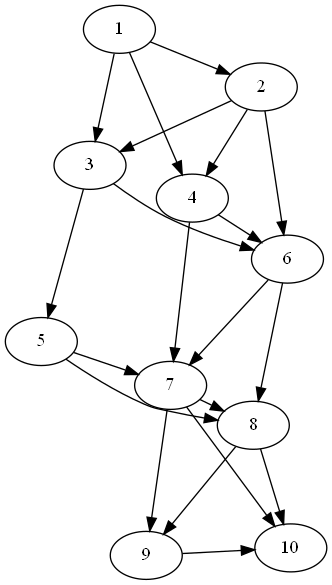

In [14]:
Image("graph.png")

In [15]:
# z = log P
z = cvx.Variable(n)
x = cvx.Variable(m)
objective = cvx.Minimize(z[n-1])
constraints = [
    A.T @ z >= -np.diag(a) @ x,
    x >= 0,
    x <= x_max,
    z[0] == 0,
    cvx.sum(x) <= B,
]
problem = cvx.Problem(objective, constraints)
log_p_max_star = problem.solve()

print(f"The best probability P^max is {np.exp(log_p_max_star)} ")

The best probability P^max is 0.043284208441142114 


In [16]:
# Uniform distribution
# z = log P
z = cvx.Variable(n)
objective = cvx.Minimize(z[n-1])
constraints = [
    A.T @ z >= -np.diag(a) @ x,
    x == B/m,
    z[0] == 0,
]
problem = cvx.Problem(objective, constraints)
log_p_max_star = problem.solve()

print(f"The best probability P^max is {np.exp(log_p_max_star)} ")

The best probability P^max is 0.2470610986991354 
